Take Home Assignment 3

3.0 Install any dependencies if needed


In [7]:
!pip install supervision


In [8]:
!pip install ultralytics

In [9]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [12]:
img = cv2.imread("/cars1.jpg")


0: 416x640 14 cars, 5808.4ms
Speed: 5.0ms preprocess, 5808.4ms inference, 31.8ms postprocess per image at shape (1, 3, 416, 640)


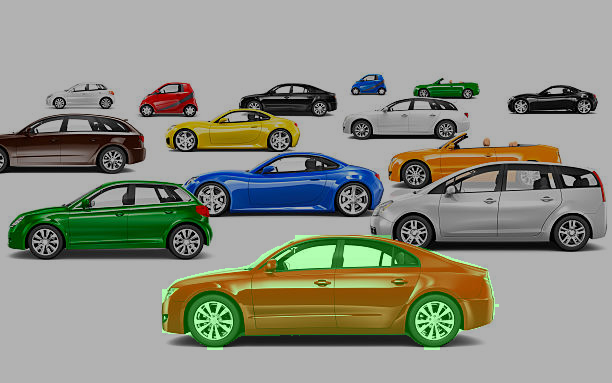

In [14]:

from IPython import get_ipython
from IPython.display import display
# %%

from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab

# Load the YOLOv8 segmentation model
model = YOLO("yolov8x-seg.pt")  # Use 'yolov8n-seg.pt' for a smaller model

# Read the image
img = cv2.imread("cars1.jpg")

# Run the segmentation model
results = model(img)

# Initialize variables for the largest car
largest_area = 0
largest_mask = None

# Iterate through detected objects
for result in results:
    for i, mask in enumerate(result.masks.xy):  # Get segmentation masks
        class_id = result.boxes.cls[i].item()  # Get class ID
        if class_id == 2:  # Class 2 corresponds to 'car' in COCO dataset
            # Convert mask to a binary image
            mask_np = np.array(mask, dtype=np.int32)

            # Compute the area of the mask
            area = cv2.contourArea(mask_np)
            if area > largest_area:
                largest_area = area
                largest_mask = mask_np

# Draw the mask if found
if largest_mask is not None:
    mask_img = np.zeros_like(img, dtype=np.uint8)
    cv2.fillPoly(mask_img, [largest_mask], (0, 255, 0))  # Green mask
    img = cv2.addWeighted(img, 0.7, mask_img, 0.3, 0)  # Blend the mask

# Display the image using cv2_imshow for Colab
cv2_imshow(img) # Use cv2_imshow instead of cv2.imshow
#cv2.waitKey(0) # These are not needed in Colab
#cv2.destroyAllWindows()

3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 6145.9ms
Speed: 3.9ms preprocess, 6145.9ms inference, 54.5ms postprocess per image at shape (1, 3, 416, 640)


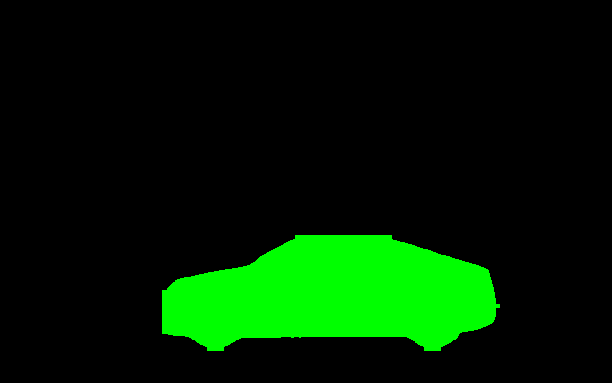

In [15]:

from ultralytics import YOLO
import supervision as sv
import cv2
from google.colab.patches import cv2_imshow

# Load the YOLOv8 segmentation model
model = YOLO("yolov8x-seg.pt")  # or any other segmentation model

# Read the image
img = cv2.imread("cars1.jpg")

# Run the segmentation model
results = model(img)[0]  # Get the first result (assuming only one image)

# Transfer ultralytics results to supervision
detections = sv.Detections.from_ultralytics(results)

# Initialize variables for the largest car
largest_area = 0
largest_mask = None

# Iterate through the masks and find the largest
for i, mask in enumerate(detections.mask):
    if detections.class_id[i] == 2:  # Class 2 corresponds to 'car' in COCO dataset
        area = mask.sum()  # Calculate the area of the mask
        if area > largest_area:
            largest_area = area
            largest_mask = mask

# Display the largest mask (if found)
if largest_mask is not None:
    # Create a blank image with the same size as the original image
    mask_img = np.zeros_like(img)

    # Set the pixels corresponding to the largest mask to green (or any color you prefer)
    mask_img[largest_mask] = (0, 255, 0)  # Green color

    # Display the mask image
    cv2_imshow(mask_img)
else:
    print("No car detected in the image.")

3.2 Estimate distance to centroid of chair

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


100%|██████████| 6.25M/6.25M [00:00<00:00, 74.0MB/s]



0: 384x640 1 chair, 169.6ms
Speed: 2.8ms preprocess, 169.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Estimated Depth at Chair's Centroid: 0.57 (normalized)


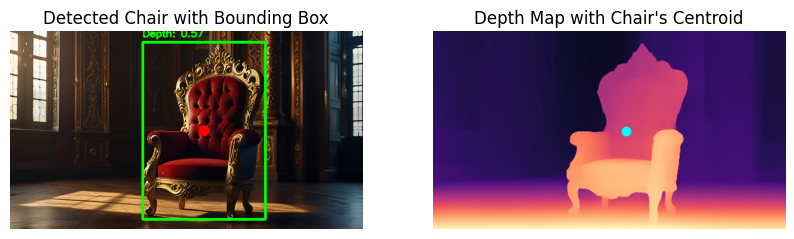

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from PIL import Image
from ultralytics import YOLO

# Load the Hugging Face depth estimation pipeline (API-based, no download)
depth_estimator = pipeline("depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")

# Load YOLOv8 model (for chair detection)
yolo_model = YOLO("yolov8n.pt")  # Uses a small YOLO model (downloaded once)

# Load and preprocess the image
img_path = "kingChair.jpg"  # Update with the correct path
img = Image.open(img_path).convert("RGB")  # Load as RGB
img_cv2 = cv2.imread(img_path)  # Load for YOLO (OpenCV uses BGR)

# Perform object detection (YOLO)
results = yolo_model(img_cv2)

# Define COCO class ID for chair
CHAIR_CLASS_ID = 56

# Find the largest chair detected
largest_area = 0
chair_centroid = None
chair_box = None  # Store the bounding box of the largest chair

for result in results:
    for i, box in enumerate(result.boxes.xyxy):  # Bounding boxes
        class_id = int(result.boxes.cls[i].item())

        if class_id == CHAIR_CLASS_ID:  # Check if detected object is a chair
            x1, y1, x2, y2 = map(int, box)  # Get bounding box coordinates

            # Compute centroid
            centroid_x = (x1 + x2) // 2
            centroid_y = (y1 + y2) // 2

            # Compute area
            area = (x2 - x1) * (y2 - y1)

            # Keep the largest chair detected
            if area > largest_area:
                largest_area = area
                chair_centroid = (centroid_x, centroid_y)
                chair_box = (x1, y1, x2, y2)  # Store bounding box

# Perform depth estimation using the pipeline
result = depth_estimator(img)
depth_map = np.array(result["depth"])
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())  # Normalize

# Get depth at the chair's centroid and draw bounding box
if chair_centroid and chair_box:
    centroid_depth = depth_map[chair_centroid[1], chair_centroid[0]]  # Depth value at centroid
    print(f"Estimated Depth at Chair's Centroid: {centroid_depth:.2f} (normalized)")

    # Draw bounding box
    x1, y1, x2, y2 = chair_box
    img_cv2 = cv2.rectangle(img_cv2, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Green box
    img_cv2 = cv2.putText(img_cv2, f"Depth: {centroid_depth:.2f}", (x1, y1 - 10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Draw centroid marker
    img_cv2 = cv2.circle(img_cv2, chair_centroid, 10, (0, 0, 255), -1)  # Red centroid marker

# Display original image with bounding box and depth map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Detected Chair with Bounding Box")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap="magma")
plt.scatter(chair_centroid[0], chair_centroid[1], color='cyan', marker='o')  # Mark centroid on depth map
plt.title("Depth Map with Chair's Centroid")
plt.axis("off")

plt.show()


3.3.1  Draw bounding boxes around the "cars" using supervision.

In [18]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown

file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: /content/vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:00<00:00, 87.5MB/s]


'vehicles_video.mp4'

In [20]:
model = YOLO("yolo11n.pt")


def callback(frame: np.ndarray, _: int) -> np.ndarray:
    # Complete this function

    sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="result_tracking.mp4",
    callback=callback
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 57.2MB/s]


3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision

In [21]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]

    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=detections)
    return label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)

sv.process_video(
    source_path="/content/vehicles_video.mp4",
    target_path="result.mp4",
    callback=callback
)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 384x640 3 cars, 1 truck, 230.3ms
Speed: 11.8ms preprocess, 230.3ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 224.4ms
Speed: 15.4ms preprocess, 224.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 267.7ms
Speed: 4.8ms preprocess, 267.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 286.7ms
Speed: 9.2ms preprocess, 286.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 267.2ms
Speed: 5.0ms preprocess, 267.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 227.9ms
Speed: 5.1ms preprocess, 227.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 168.8ms
Speed: 5.4ms preprocess, 168.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 153

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [24]:
import numpy as np
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}"
        for class_id, tracker_id
        in zip(detections.class_id, detections.tracker_id)
    ]

    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)
    return trace_annotator.annotate(
        annotated_frame, detections=detections)

sv.process_video(
    source_path="/content/vehicles_video.mp4",
    target_path="result.mp4",
    callback=callback
)

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 384x640 3 cars, 1 truck, 131.5ms
Speed: 3.6ms preprocess, 131.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 144.5ms
Speed: 7.9ms preprocess, 144.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 158.8ms
Speed: 4.6ms preprocess, 158.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 165.3ms
Speed: 4.9ms preprocess, 165.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 152.6ms
Speed: 4.5ms preprocess, 152.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 142.5ms
Speed: 4.6ms preprocess, 142.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 177.0ms
Speed: 5.2ms preprocess, 177.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 156.1

KeyboardInterrupt: 

Questions:

Explain what "def callback(frame: np.ndarray, _: int) -> np.ndarray:" does.

Answers: Complete this section